In [1]:
import ctypes
import numpy as np
from typing import Union, List
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def plot_log_residual_contour(x_true, x_recon, gmm=None, varname="pt"):
    # Calculate residuals and transform to log scale
    residual = x_true - x_recon
    log_x_true = np.log10(np.abs(x_recon) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    
    # Create grid for contours
    x_min, x_max = np.percentile(log_x_true, [1, 99.9])
    y_min, y_max = np.percentile(log_residual, [1, 99.9])
    
    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        log_x_true, log_residual, 
        bins=100, 
        range=[[x_min, x_max], [y_min, y_max]],
        density=True
    )
    
    # Smooth the histogram
    hist_smooth = gaussian_filter1d(hist, sigma=1)
    
    # Create meshgrid for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    xx, yy = np.meshgrid(x_centers, y_centers)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Contour plot of actual data
    levels = np.linspace(0, hist_smooth.max(), 50)
    cs = plt.contourf(xx, yy, hist_smooth.T, levels=levels, cmap='viridis', alpha=0.7)
    plt.colorbar(cs, label='Density')
    
    # Plot GMM components if provided
    if gmm is not None:
        # Create evaluation grid
        grid = np.column_stack([xx.ravel(), yy.ravel()])
        scores = gmm.score_samples(grid)
        scores = np.exp(scores).reshape(xx.shape)
        
        # Plot GMM contours
        gmm_levels = np.linspace(0, scores.max(), 10)
        plt.contour(xx, yy, scores, levels=gmm_levels, colors='red', linewidths=1, alpha=0.7)
        
        # Plot component means
        plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
                   c='red', s=100, marker='x', label='GMM Means')
        plt.scatter(gmm.means_[:, 0], -gmm.means_[:, 1], 
                   c='blue', s=100, marker='o', label='Mirrored Means')
    
    # Formatting
    plt.title(f'Log-Scale Residual vs True Value: {varname}')
    plt.xlabel('log10(|True Value|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add marginal distributions
    ax = plt.gca()
    ax_top = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_right = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    
    # Top marginal (log|x_true| distribution)
    ax_top.hist(log_x_true, bins=x_centers, density=True, color='gray', alpha=0.7)
    ax_top.set_yticks([])
    
    # Right marginal (log|residual| distribution)
    ax_right.hist(log_residual, bins=y_centers, density=True, 
                 orientation='horizontal', color='gray', alpha=0.7)
    ax_right.set_xticks([])
    
    plt.tight_layout()
    plt.show()


class FloatCompressor:
    """Python equivalent of CxxUtils::FloatCompressor"""
    def __init__(self, nmantissa: int):
        self.nmantissa = nmantissa
    
    def reduceFloatPrecision(self, value: float) -> float:
        """Reduce float precision by truncating mantissa bits"""
        if self.nmantissa >= 23 or self.nmantissa == 0:
            return value
            
        # Convert float to 32-bit binary representation
        packed = ctypes.pointer(ctypes.c_uint32.from_buffer(ctypes.c_float(value)))
        bits = packed.contents.value
        
        # Extract sign, exponent, and mantissa
        sign = bits >> 31
        exponent = (bits >> 23) & 0xFF
        mantissa = bits & 0x7FFFFF
        
        # Truncate mantissa
        shift = 23 - self.nmantissa
        truncated_mantissa = (mantissa >> shift) << shift
        
        # Reconstruct float
        new_bits = (sign << 31) | (exponent << 23) | truncated_mantissa
        packed_new = ctypes.pointer(ctypes.c_uint32(new_bits))
        return ctypes.c_float.from_buffer(packed_new.contents).value

# Initialize compressors once (equivalent to static in C++)
NMANTISSA_MAX = 23
compressors = [FloatCompressor(i) for i in range(NMANTISSA_MAX)]

def lossy_float_compress(
    dst: Union[np.ndarray, List[List[float]]], 
    idst: int, 
    n: int, 
    elt_size: int, 
    type_name: str, 
    nmantissa: int
) -> None:
    """
    Python version of SG::lossyFloatCompress
    
    Args:
        dst: Input buffer (either float array or list of float lists)
        idst: Starting index in buffer
        n: Number of elements to process
        elt_size: Size of each element (unused in Python)
        type_name: "float" or "std::vector<float>"
        nmantissa: Number of mantissa bits to keep (1-22)
    """
    if nmantissa == 0 or nmantissa >= NMANTISSA_MAX:
        return
    
    compressor = compressors[nmantissa]
    
    if type_name == "float":
        # Handle raw float array
        arr = dst[idst:idst+n]
        for i in range(n):
            arr[i] = compressor.reduceFloatPrecision(arr[i])
            
    elif type_name == "std::vector<float>":
        # Handle list of float lists
        for i in range(n):
            vec = dst[idst + i]
            for j in range(len(vec)):
                vec[j] = compressor.reduceFloatPrecision(vec[j])



def analyze_peak_spacing(log_peaks_dict):
    print("\n🔍 Log-Scale Peak Spacing Analysis:")

    all_diffs = []  # store all Δlog10 spacing values
    equidistant_vars = []

    for var, log_peaks in log_peaks_dict.items():
        if len(log_peaks) < 2:
            print(f"  • {var}: Less than 2 peaks found.")
            continue

        diffs = np.diff(log_peaks)
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        all_diffs.extend(diffs)

        is_equidistant = std_diff < 0.05 * mean_diff  # adjustable threshold
        print(f"\n adaptive threshold: {std_diff:.3f} < 0.05 * {mean_diff:.3f} = {0.05 * mean_diff:.3f}")
        spacing_str = "✅ Approx. equidistant" if is_equidistant else "❌ Not equidistant"
        if is_equidistant:
            equidistant_vars.append(var)

        print(f"  • {var}: mean Δlog10 = {mean_diff:.3f}, std = {std_diff:.3f} → {spacing_str}")

    # Compute global stats
    if all_diffs:
        global_mean = np.mean(all_diffs)
        global_std = np.std(all_diffs)
        print(f"\n📊 Global mean Δlog10 spacing = {global_mean:.3f}, std = {global_std:.3f}")
    else:
        print("\n⚠️ Not enough peak data to compute global spacing.")
    return global_mean, global_std

def reduce_float_precision(value, nmantissa):
    # Constants
    NMANTISSA = 23
    MAX_EXPONENT = 0x7f7  # corresponds to max exponent before Inf (254 in biased form)
    MIN_MANTISSA_BITS = 5

    # Convert float32 to raw bits
    float_val = ctypes.c_float(value)
    bits = ctypes.cast(ctypes.pointer(float_val), ctypes.POINTER(ctypes.c_uint32)).contents.value

    # Handle NaN and Inf (do not compress)
    if (bits & 0x7f800000) == 0x7f800000:
        return value  # Already Inf/NaN

    # If full mantissa requested, or invalid range, return original
    if nmantissa >= NMANTISSA or nmantissa <= 0:
        return value

    # Clamp to minimum mantissa
    if nmantissa < MIN_MANTISSA_BITS:
        nmantissa = MIN_MANTISSA_BITS

    # Compute shift and masks
    shift = NMANTISSA - nmantissa
    mask = (~0) << shift  # Keeps upper nmantissa bits
    round_bit = 1 << (shift - 1)

    mantissa = bits & 0x007fffff
    exponent = (bits >> 23) & 0xff

    # Create a mask for vmax check (from C++)
    vmax = (MAX_EXPONENT << 23) | (0x007fffff ^ round_bit)

    # Perform rounding if it won't cause overflow
    if (bits & 0x7fffffff) < vmax:
        mantissa += round_bit

    # Apply mantissa mask (truncate lower bits)
    mantissa &= mask

    # Reassemble final bits
    compressed_bits = (bits & 0xff800000) | mantissa  # keep sign and exponent

    # Convert bits back to float32
    compressed_uint = ctypes.c_uint32(compressed_bits)
    compressed_float = ctypes.cast(ctypes.pointer(compressed_uint), ctypes.POINTER(ctypes.c_float)).contents.value

    return compressed_float



Compression with nmantissa=8:
Max absolute error: 1.048e+06
Median relative error: 6.507e-04
95th percentile relative error: 1.427e-03


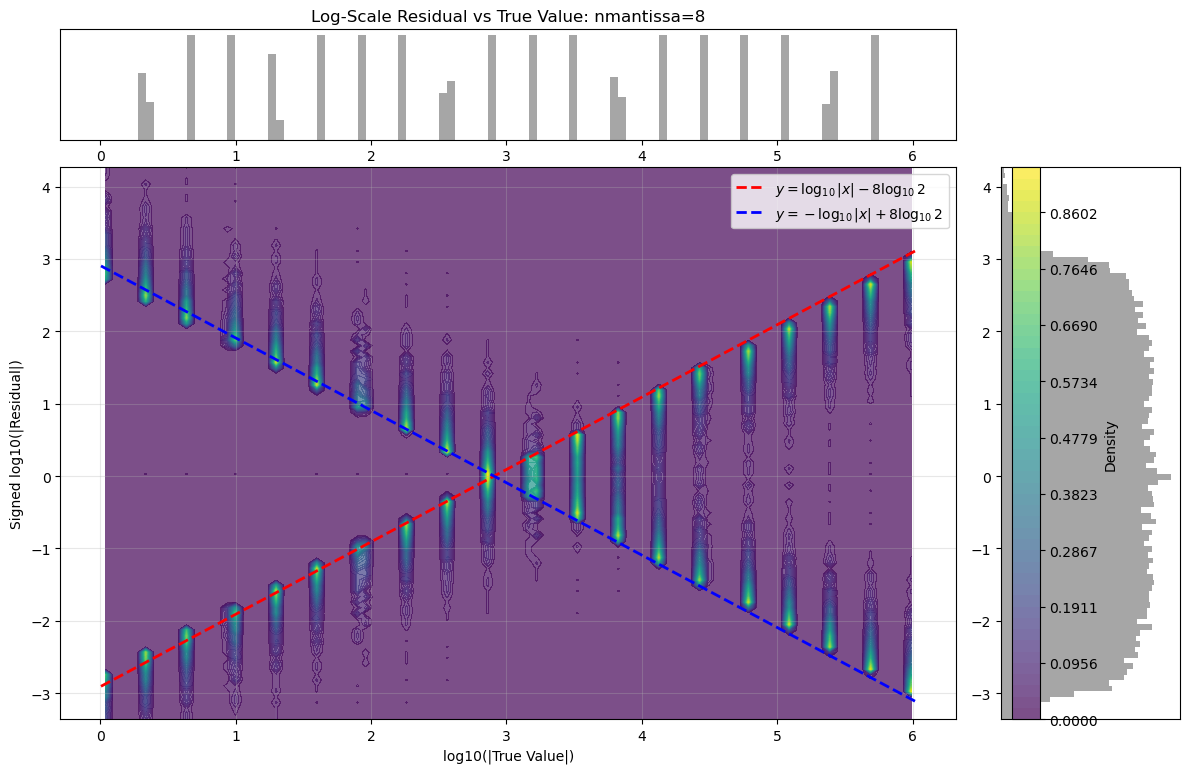

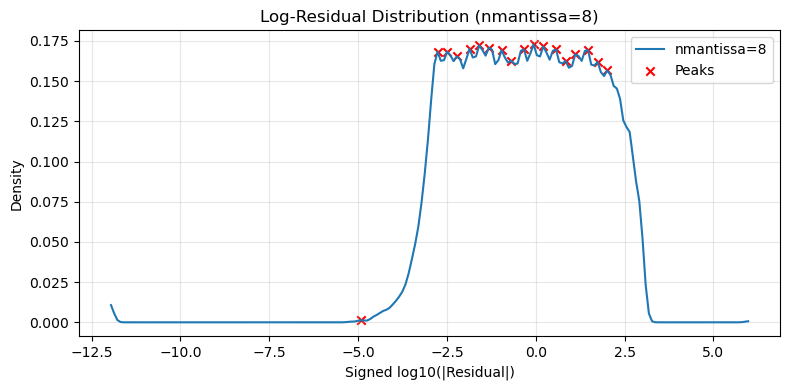


Compression with nmantissa=10:
Max absolute error: 1.048e+06
Median relative error: 1.628e-04
95th percentile relative error: 3.563e-04


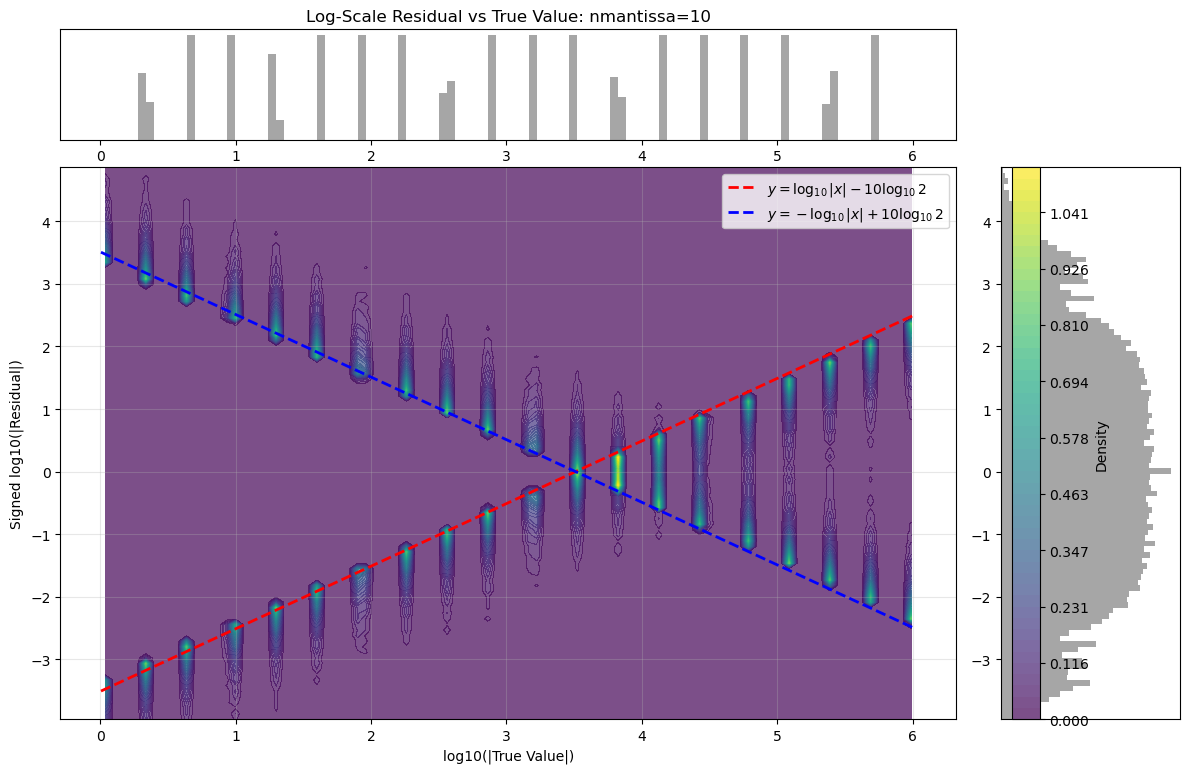

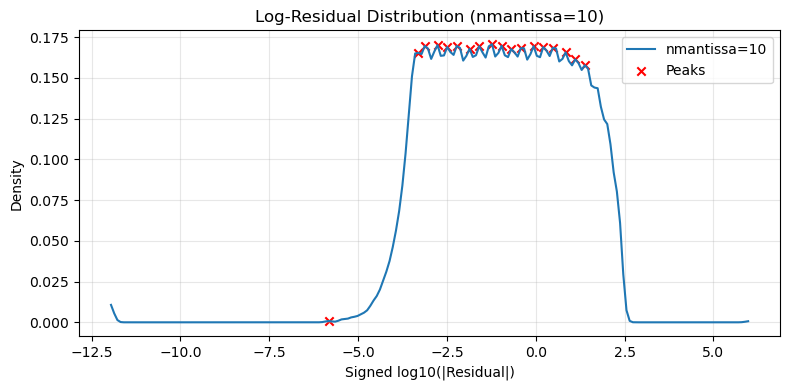


Compression with nmantissa=15:
Max absolute error: 8.875e+00
Median relative error: 5.088e-06
95th percentile relative error: 1.114e-05


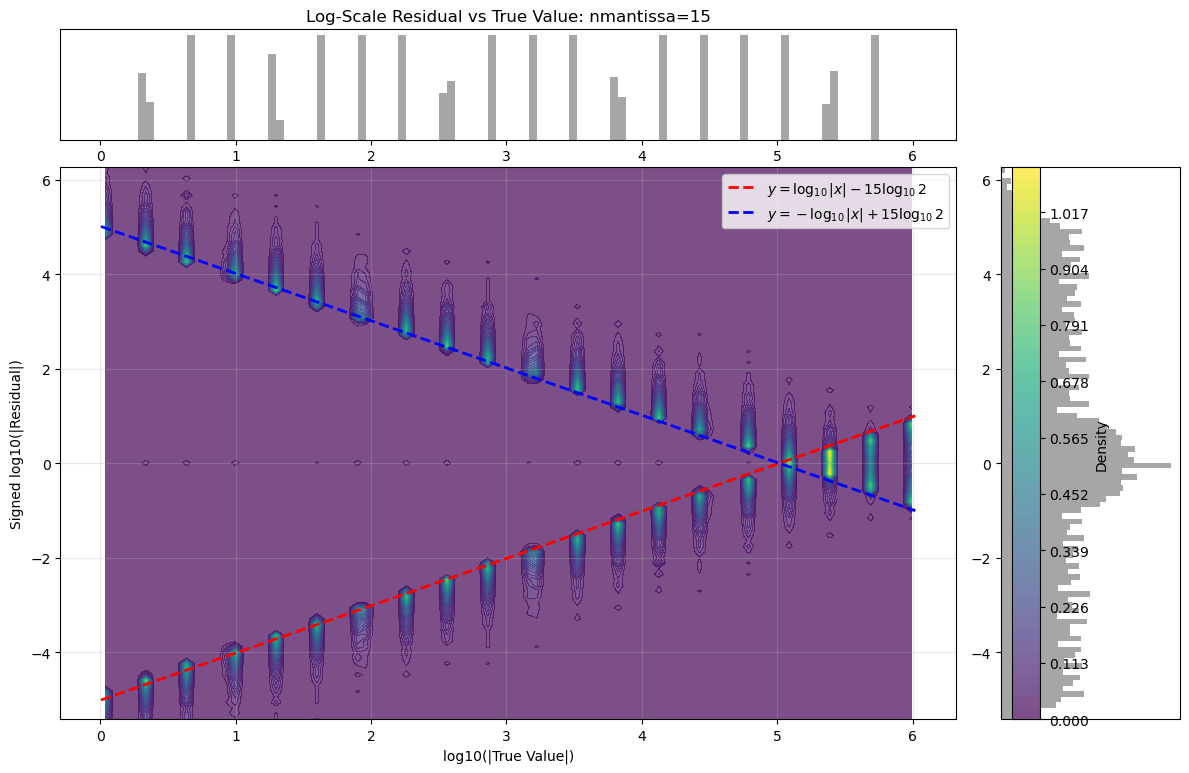

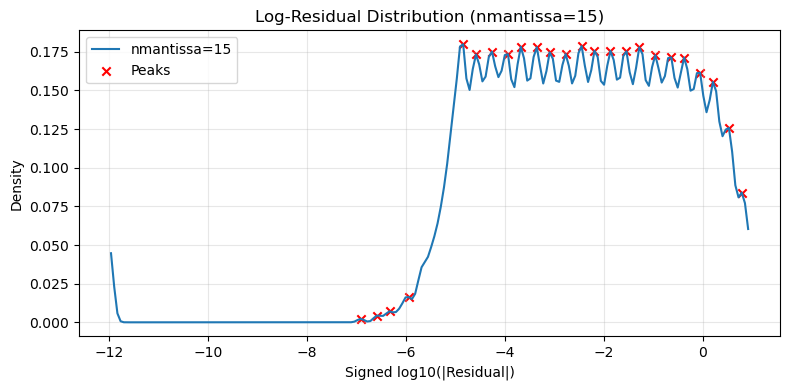


Compression with nmantissa=20:
Max absolute error: 2.500e-01
Median relative error: 1.586e-07
95th percentile relative error: 3.507e-07


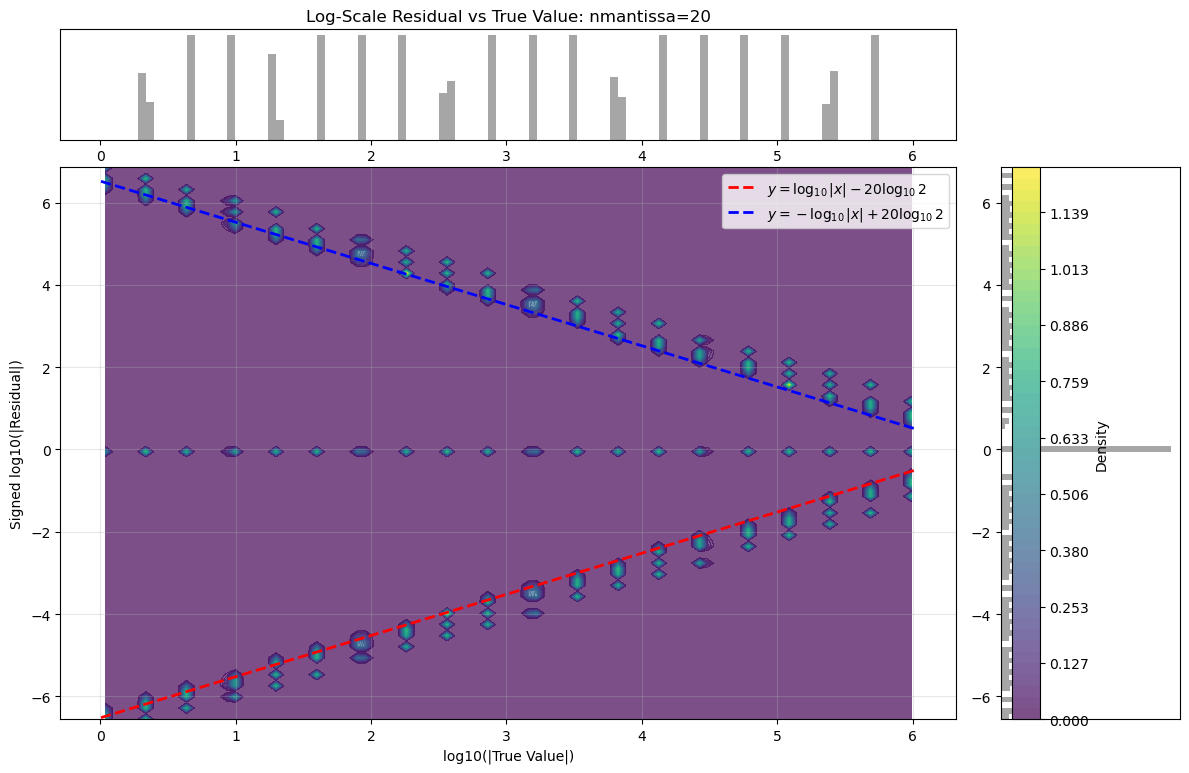

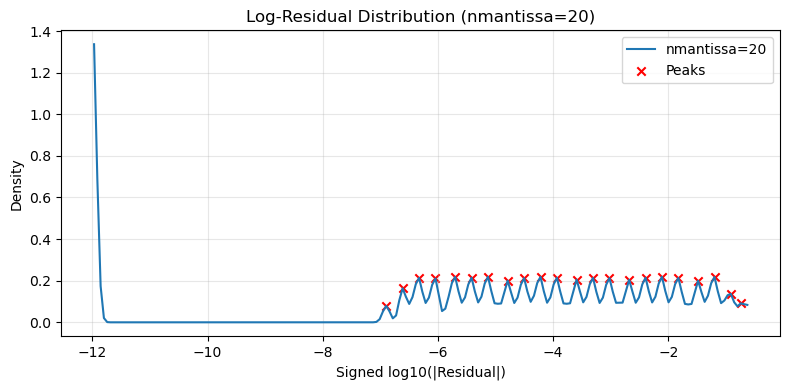


Compression with nmantissa=23:
Max absolute error: 0.000e+00
Median relative error: 0.000e+00
95th percentile relative error: 0.000e+00


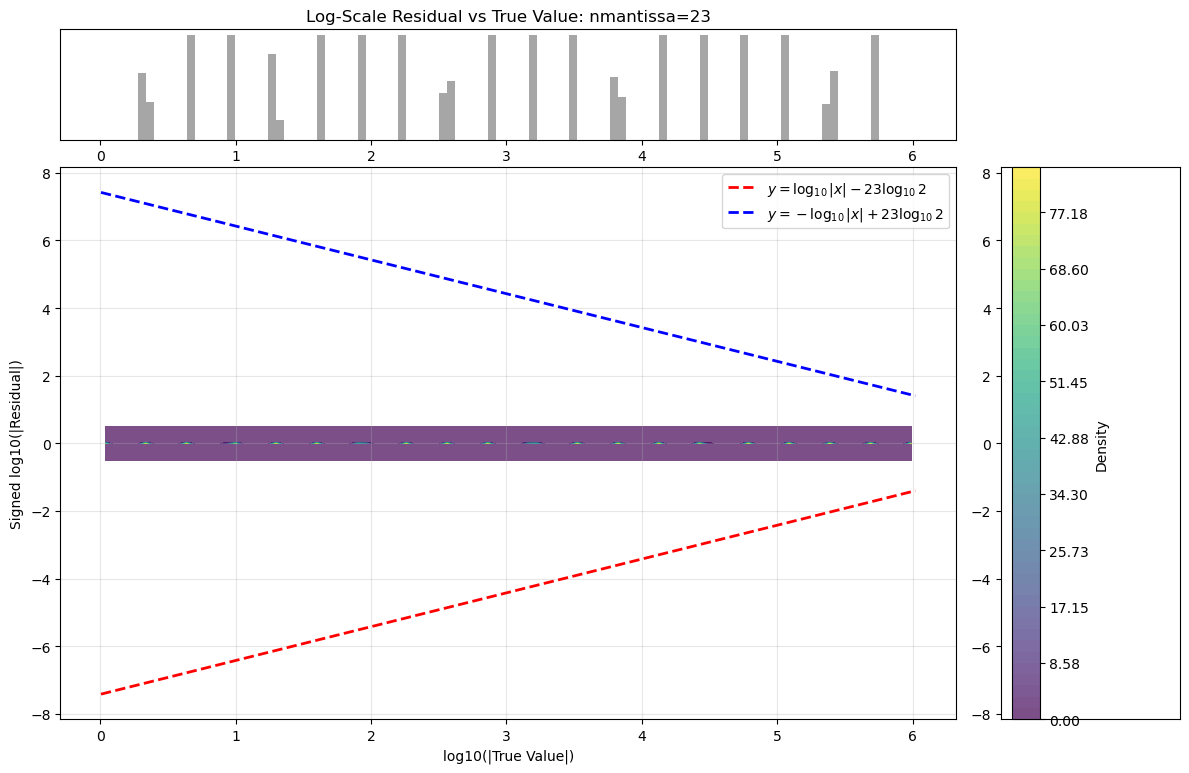

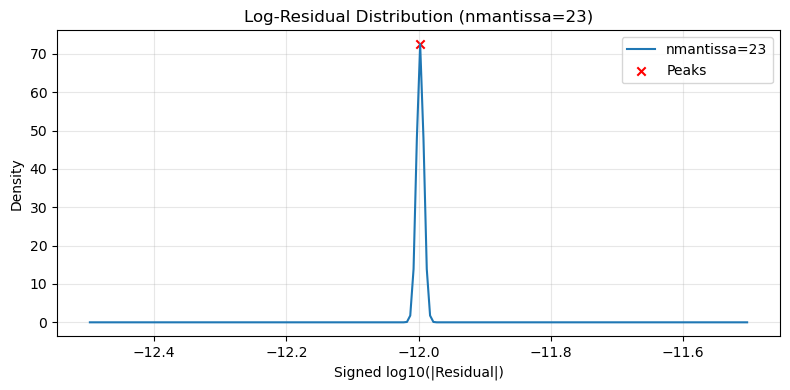


🔍 Log-Scale Peak Spacing Analysis:

 adaptive threshold: 0.440 < 0.05 * 0.408 = 0.020
  • nmantissa=8: mean Δlog10 = 0.408, std = 0.440 → ❌ Not equidistant

 adaptive threshold: 0.527 < 0.05 * 0.424 = 0.021
  • nmantissa=10: mean Δlog10 = 0.424, std = 0.527 → ❌ Not equidistant

 adaptive threshold: 0.167 < 0.05 * 0.335 = 0.017
  • nmantissa=15: mean Δlog10 = 0.335, std = 0.167 → ❌ Not equidistant

 adaptive threshold: 0.036 < 0.05 * 0.293 = 0.015
  • nmantissa=20: mean Δlog10 = 0.293, std = 0.036 → ❌ Not equidistant
  • nmantissa=23: Less than 2 peaks found.

📊 Global mean Δlog10 spacing = 0.359, std = 0.338


(0.35904082836354706, 0.3379225322623241)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import ldexp
from scipy.ndimage import gaussian_filter1d

def generate_logarithmic_floats(num_samples=1000):
    min_exp, max_exp = 0, 20
    exponents = np.linspace(min_exp, max_exp, num_samples, dtype=np.float32)
    mantissas = np.linspace(1.0, 2.0, num_samples, endpoint=False, dtype=np.float32)
    values = [ldexp(man, int(exp)) for exp, man in zip(exponents, mantissas)]
    values += [-v for v in values]
    # values += [0.0, -0.0, float('inf'), -float('inf'), float('nan')]
    return np.array(values, dtype=np.float32)

def plot_log_residual_contour(x_true, residual, gmm=None, varname="pt", m=10):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d

    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)

    x_min, x_max = np.percentile(log_x_true, [1, 99.9])
    y_min, y_max = np.percentile(log_residual, [1, 99.9])

    hist, x_edges, y_edges = np.histogram2d(
        log_x_true, log_residual, bins=100,
        range=[[x_min, x_max], [y_min, y_max]], density=True
    )
    hist_smooth = hist #gaussian_filter1d(hist, sigma=1)

    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    xx, yy = np.meshgrid(x_centers, y_centers)

    plt.figure(figsize=(12, 8))
    levels = np.linspace(0, hist_smooth.max(), 50)
    cs = plt.contourf(xx, yy, hist_smooth.T, levels=levels, cmap='viridis', alpha=0.7)
    plt.colorbar(cs, label='Density')

    # Plot theoretical bounds
    C = -m * np.log10(2) - 0.5
    x_vals = np.linspace(x_min, x_max, 1000)
    y_upper = x_vals + C
    y_lower = -x_vals - C
    plt.plot(x_vals, y_upper, 'r--', linewidth=2, label=f'$y = \log_{{10}}|x| - {m}\log_{{10}}2$')
    plt.plot(x_vals, y_lower, 'b--', linewidth=2, label=f'$y = -\log_{{10}}|x| + {m}\log_{{10}}2$')

    # GMM overlay
    if gmm is not None:
        grid = np.column_stack([xx.ravel(), yy.ravel()])
        scores = gmm.score_samples(grid)
        scores = np.exp(scores).reshape(xx.shape)
        gmm_levels = np.linspace(0, scores.max(), 10)
        plt.contour(xx, yy, scores, levels=gmm_levels, colors='red', linewidths=1, alpha=0.7)
        plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=100, marker='x', label='GMM Means')
        plt.scatter(gmm.means_[:, 0], -gmm.means_[:, 1], c='blue', s=100, marker='o', label='Mirrored Means')

    plt.title(f'Log-Scale Residual vs True Value: {varname}')
    plt.xlabel('log10(|True Value|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Marginal histograms
    ax = plt.gca()
    ax_top = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_right = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

    ax_top.hist(log_x_true, bins=x_centers, density=True, color='gray', alpha=0.7)
    ax_top.set_yticks([])

    ax_right.hist(log_residual, bins=y_centers, density=True,
                  orientation='horizontal', color='gray', alpha=0.7)
    ax_right.set_xticks([])

    plt.tight_layout()
    plt.show()


def analyze_compression(original, compressed, nmantissa):
    mask = np.isfinite(original) & np.isfinite(compressed)
    orig_finite = original[mask]
    comp_finite = compressed[mask]
    abs_errors = np.abs(orig_finite - comp_finite)
    rel_errors = np.abs((orig_finite - comp_finite) / orig_finite)

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 3, 1)
    # plt.loglog(np.abs(orig_finite), np.abs(comp_finite), '.', alpha=0.5)
    # plt.plot([0, 1e8], [0,1e8], 'r--')
    # plt.xlabel('Original Value (abs)')
    # plt.ylabel('Compressed Value (abs)')
    # plt.title(f'Value Comparison (nmantissa={nmantissa})')

    # plt.subplot(1, 3, 2)
    # plt.loglog(np.abs(orig_finite), abs_errors, '.', alpha=0.5)
    # plt.xlabel('Original Value (abs)')
    # plt.ylabel('Absolute Error')
    # plt.title('Absolute Error Analysis')

    # plt.subplot(1, 3, 3)
    # plt.loglog(np.abs(orig_finite), rel_errors, '.', alpha=0.5)
    # plt.xlabel('Original Value (abs)')
    # plt.ylabel('Relative Error')
    # plt.title('Relative Error Analysis')

    # plt.tight_layout()
    # plt.show()

    print(f"\nCompression with nmantissa={nmantissa}:")
    print(f"Max absolute error: {np.max(abs_errors):.3e}")
    print(f"Median relative error: {np.median(rel_errors):.3e}")
    print(f"95th percentile relative error: {np.percentile(rel_errors, 95):.3e}")

    # Log-scale residual visualization
    residuals = comp_finite - orig_finite
    plot_log_residual_contour(orig_finite, residuals, gmm=None, varname=f"nmantissa={nmantissa}", m=nmantissa)
    return orig_finite, comp_finite, abs_errors, rel_errors

def extract_log_peaks(residuals, nmantissa):
    log_res = np.log10(np.abs(residuals) + 1e-12)
    hist, bin_edges = np.histogram(log_res, bins=200, density=True)
    smoothed = gaussian_filter1d(hist, sigma=1.1)
    peaks, _ = find_peaks(smoothed)
    log_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot smoothed histogram
    plt.figure(figsize=(8, 4))
    plt.plot(log_centers, smoothed, label=f'nmantissa={nmantissa}')
    plt.scatter(log_centers[peaks], smoothed[peaks], color='red', marker='x', label='Peaks')
    plt.xlabel('Signed log10(|Residual|)')
    plt.ylabel('Density')
    plt.title(f'Log-Residual Distribution (nmantissa={nmantissa})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return log_centers[peaks]


# Run the full pipeline
test_values = generate_logarithmic_floats(10000)
log_peaks_dict = {}

for nmantissa in [8,10,15,20,23]:
    # compressed_values = test_values.copy()
    compressed_values = np.vectorize(reduce_float_precision)(test_values, nmantissa=nmantissa)
    # lossy_float_compress(
    #     dst=compressed_values,
    #     idst=0,
    #     n=len(compressed_values),
    #     elt_size=4,
    #     type_name="float",
    #     nmantissa=nmantissa
    # )
    orig_finite, comp_finite, abs_errors, rel_errors =analyze_compression(test_values, compressed_values, nmantissa)

    # Extract residual peaks
    mask = np.isfinite(test_values) & np.isfinite(compressed_values)
    residual = compressed_values[mask] - test_values[mask]
    log_peaks_dict[f"nmantissa={nmantissa}"] = extract_log_peaks(residual, nmantissa)

# Analyze spacing between the peaks
analyze_peak_spacing(log_peaks_dict)

/tmp/yolanney/ipykernel_3430996/3204759460.py:56: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contourf(xx, yy, density, levels=levels,


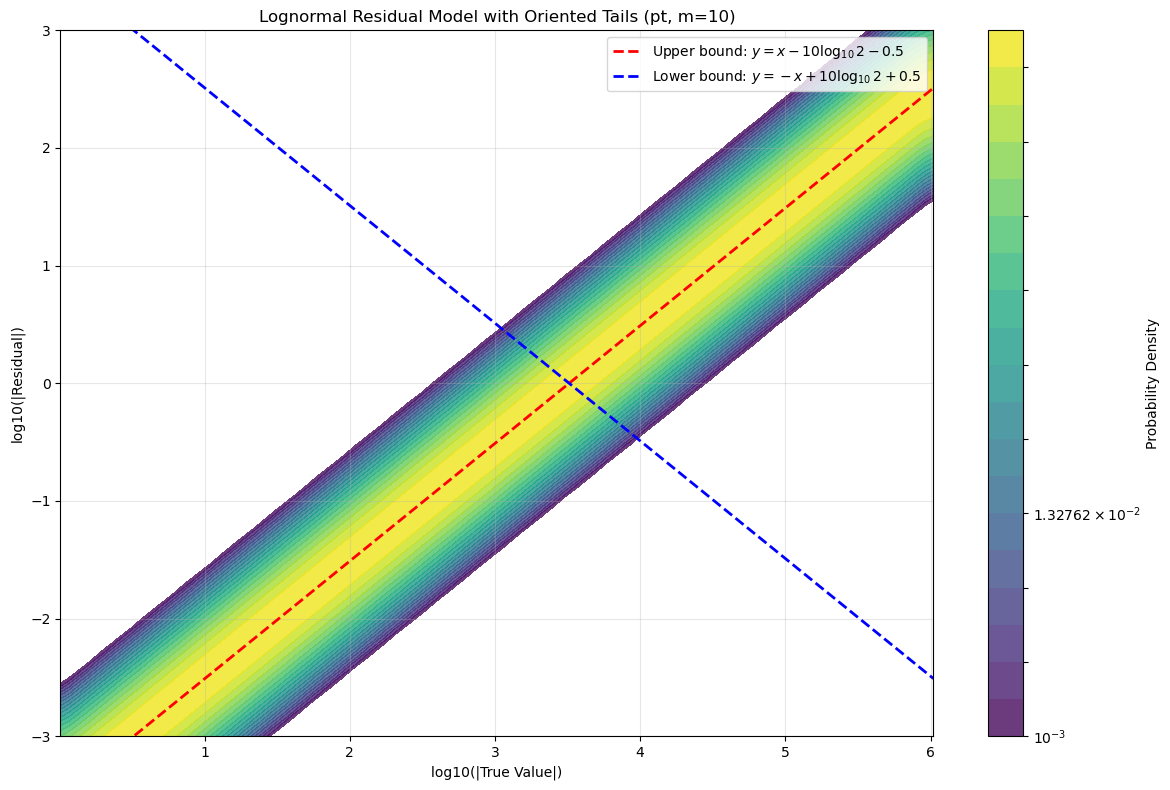

In [10]:
def plot_lognormal_residual_model(x_true, m=10, varname="pt"):
    """
    Plots a contour map of lognormal residual distributions with:
    - Upper bound: Distributions tailing downward
    - Lower bound: Distributions tailing upward
    
    Args:
        x_true: Array of true values (to determine x-range)
        m: Number of mantissa bits used in compression
        varname: Variable name for labeling
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import lognorm
    from scipy.ndimage import gaussian_filter
    from matplotlib.colors import LogNorm

    # Calculate log10 of absolute values
    log_x = np.log10(np.abs(x_true) + 1e-12)
    x_min, x_max = np.percentile(log_x, [1, 99.9])
    
    # Theoretical residual bound parameters
    C = -m * np.log10(2) - 0.5  # Bound offset
    sigma = 0.2  # Shape parameter for lognormal (adjust as needed)
    
    # Create grid
    x_grid = np.linspace(x_min, x_max, 100)
    y_grid = np.linspace(-5, 5, 200)  # Wider y-range for better visualization
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    
    # Initialize density matrix
    density = np.zeros_like(xx)
    
    # For each x value, compute properly oriented lognormal distributions
    for i, x in enumerate(x_grid):
        # Upper bound distribution (tails downward)
        upper_bound = x + C
        upper_dist = lognorm(s=sigma, scale=np.exp(upper_bound))
        upper_pdf = upper_dist.pdf(np.exp(yy[:, i])) * np.exp(yy[:, i])  # Jacobian correction
        
        # Lower bound distribution (tails upward)
        lower_bound = -x - C
        lower_dist = lognorm(s=sigma, scale=np.exp(lower_bound))
        lower_pdf = lower_dist.pdf(np.exp(-yy[:, i])) * np.exp(-yy[:, i])  # Flipped and corrected
        
        density[:, i] = upper_pdf + lower_pdf
    
    # Apply smoothing
    density = gaussian_filter(density, sigma=1.5)
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Contour plot (log scale for better visibility)
    levels = np.logspace(-3, np.log10(density.max()), 20)
    cs = plt.contourf(xx, yy, density, levels=levels, 
                     cmap='viridis', norm=LogNorm(), alpha=0.8)
    plt.colorbar(cs, label='Probability Density')
    
    # Plot theoretical bounds
    plt.plot(x_grid, x_grid + C, 'r--', linewidth=2, 
             label=f'Upper bound: $y = x - {m}\\log_{{10}}2 - 0.5$')
    plt.plot(x_grid, -x_grid - C, 'b--', linewidth=2,
             label=f'Lower bound: $y = -x + {m}\\log_{{10}}2 + 0.5$')
    
    # Formatting
    plt.title(f'Lognormal Residual Model with Oriented Tails ({varname}, m={m})')
    plt.xlabel('log10(|True Value|)')
    plt.ylabel('log10(|Residual|)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(-3, 3)  # Adjust based on your data
    plt.tight_layout()
    plt.show()

plot_lognormal_residual_model(orig_finite, m=10, varname="pt")

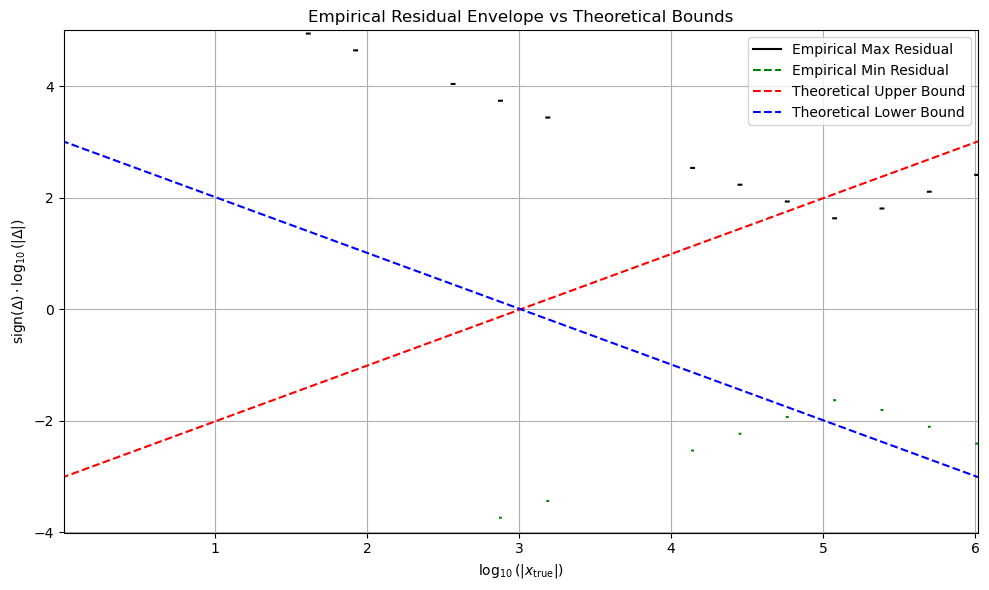

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

def compute_residual_envelope(log_x_true, log_residual, num_bins=1000):
    bin_max, bin_edges, _ = binned_statistic(
        log_x_true, log_residual, statistic='max', bins=num_bins
    )
    bin_min, _, _ = binned_statistic(
        log_x_true, log_residual, statistic='min', bins=bin_edges
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, bin_min, bin_max

def plot_empirical_vs_theoretical_bounds(x_true, residual, m=10):
    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    x_min, x_max = np.percentile(log_x_true, [1, 99.9])
    y_min, y_max = np.percentile(log_residual, [1, 99.9])
    # take the 99th percentile of the residuals
    bin_centers, bin_min, bin_max = compute_residual_envelope(log_x_true, log_residual)

    C = m * np.log10(2)
    y_upper = bin_centers - C
    y_lower = -bin_centers + C

    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, bin_max, 'k-', label='Empirical Max Residual')
    plt.plot(bin_centers, bin_min, 'g--', label='Empirical Min Residual')
    plt.plot(bin_centers, y_upper, 'r--', label='Theoretical Upper Bound')
    plt.plot(bin_centers, y_lower, 'b--', label='Theoretical Lower Bound')

    plt.xlabel(r'$\log_{10}(|x_{\mathrm{true}}|)$')
    plt.ylabel(r'$\mathrm{sign}(\Delta) \cdot \log_{10}(|\Delta|)$')
    plt.title('Empirical Residual Envelope vs Theoretical Bounds')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return bin_centers, bin_min, bin_max

bin_centers, bin_min, bin_max = plot_empirical_vs_theoretical_bounds(orig_finite, orig_finite-comp_finite, m=10)
